# Whole brain data processing

In [7]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import fish_proc.wholeBrainDask.cellProcessing_single_WS as fwc
import dask.array as da
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

df = pd.read_csv('../Processing/data_list.csv')
row = df.iloc[3]
save_root = row['save_dir']+'/'
print(save_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190927/fish02/6dpf_HuC-GC7F_statemod-fwd_fish02_exp03_20190928_003228//


In [8]:
brain_map = np.load(save_root+'Y_ave.npy')

In [9]:
_ = np.load(save_root+'cell_raw_dff_sparse.npz', allow_pickle=True)
A = _['A'].astype('float')
F_ = _['F'].astype('float')
A_loc = _['A_loc']
_ = None
# first remove components with low signals
valid_cell = F_.max(axis=-1)>20
A = A[valid_cell]
A_loc = A_loc[valid_cell]
F_ = F_[valid_cell]
F_dask = da.from_array(F_, chunks=('auto', -1))
baseline_ = da.map_blocks(fwc.baseline, F_dask, dtype='float', window=400, percentile=20, downsample=10).compute()
dFF = F_/baseline_-1
invalid_ = (dFF.max(axis=-1)>5) | (np.isnan(dFF.max(axis=-1))) | (baseline_.min(axis=-1)<=0)

In [10]:
A_ext = np.zeros(brain_map.shape[:-1]).astype('int')
for n_, A_ in enumerate(A):
    if invalid_[n_]:
        continue
    A_loc_ = A_loc[n_]
    z, x, y = A_loc_
    _ = (A_>A_.max()*0.4).astype('int')*(n_+1)
    cx, cy = A_ext[z, x:x+100, y:y+100].shape
    A_ext[z, x:x+100, y:y+100]=np.maximum(A_ext[z, x:x+100, y:y+100], _[:cx, :cy])

## plot whole brain segmentation

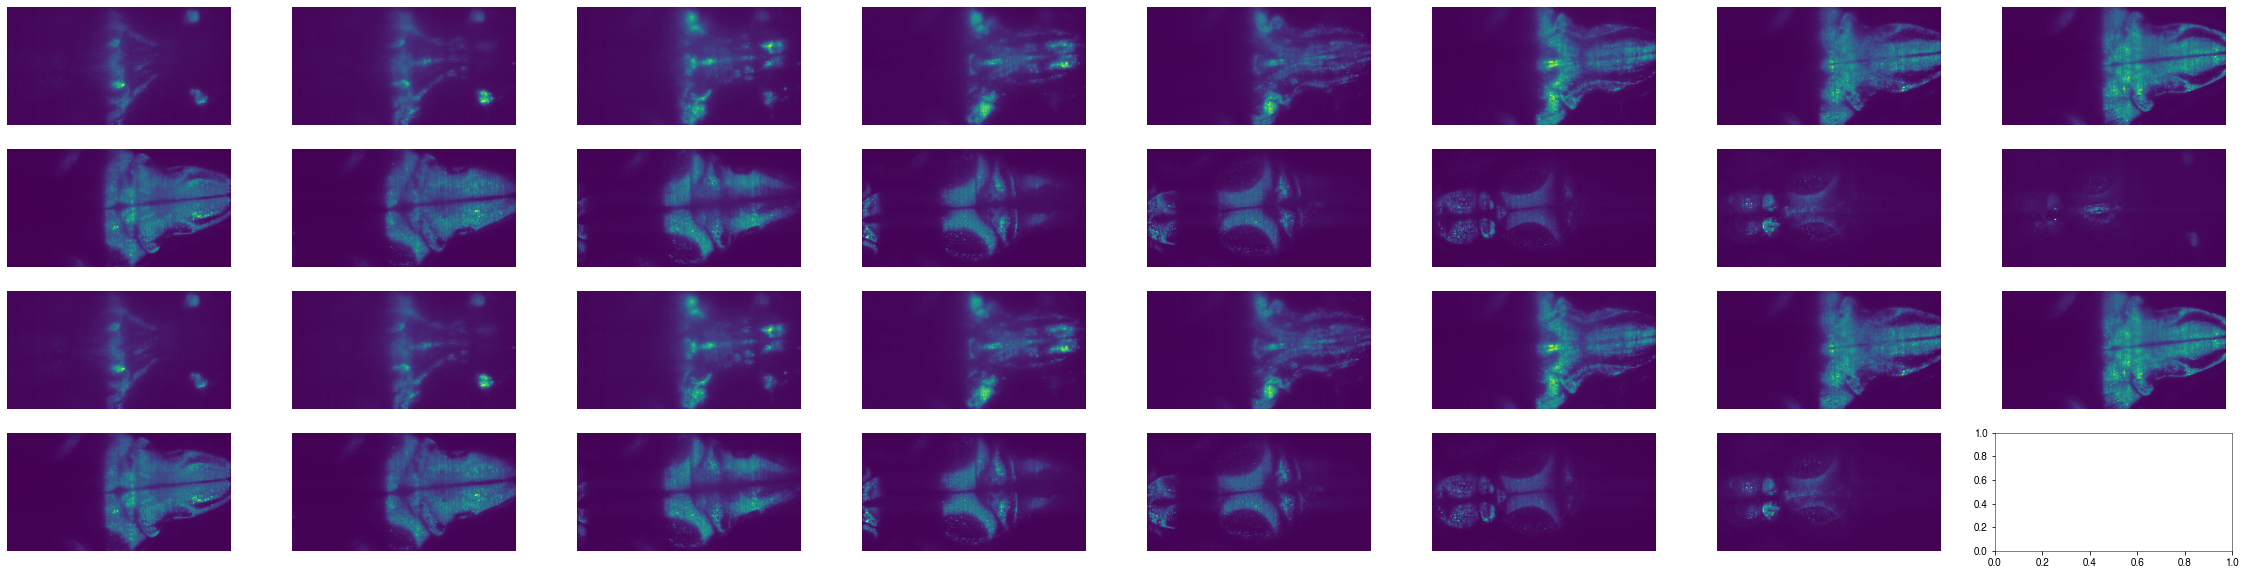

In [14]:
fig, ax = plt.subplots(4, brain_map.shape[0]//4+1, figsize=(40, 10))
ax = ax.flatten()
for n, _ in enumerate(brain_map):
    ax[n].imshow(_.squeeze().astype('float'))
    ax[n].axis('off')
plt.show()

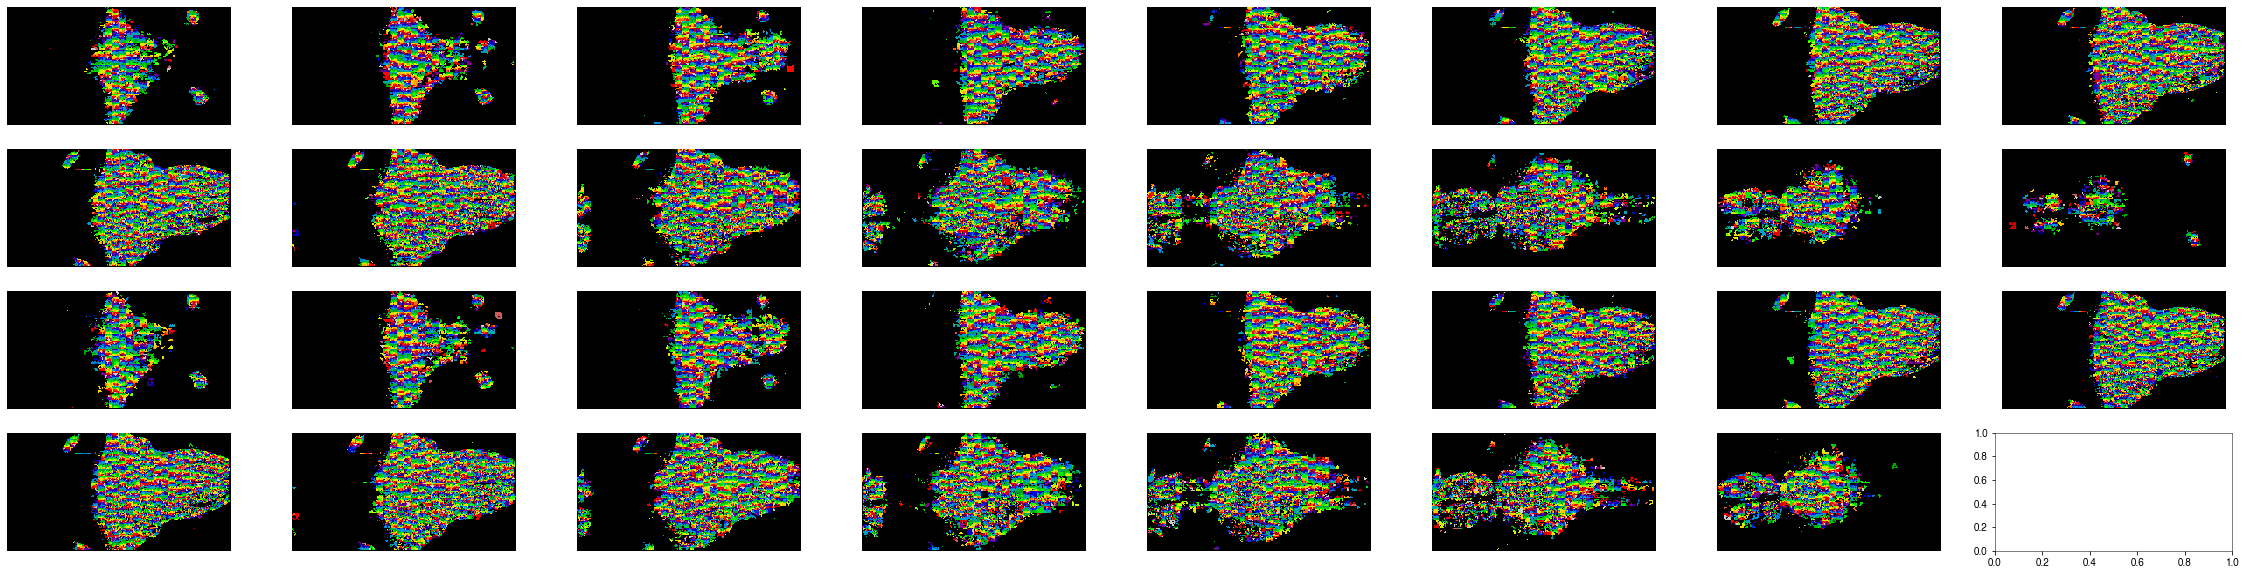

In [11]:
fig, ax = plt.subplots(4, A_ext.shape[0]//4+1, figsize=(40, 10))
ax = ax.flatten()
for n, _ in enumerate(A_ext):
    _[_>0] = _[_>0]%32+1
    ax[n].imshow(_, cmap=plt.cm.nipy_spectral)
    ax[n].axis('off')
plt.show()

In [12]:
np.savez(save_root+'cell_dff.npz', A=A[~invalid_].astype('float16'), A_loc=A_loc[~invalid_], dFF=dFF[~invalid_].astype('float16'))